In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
from pathlib import Path
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
import visualize
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline 

p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
import pandas as pd
DATA_DIR = '../data/'

# Directory to save logs and trained model
MODEL_DIR = os.path.join(DATA_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(DATA_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(DATA_DIR, "volleyball", "images_subset")

In [ ]:
DETECTIONS_DIR = Path(DATA_DIR, 'volleyball', 'detections')
DETECTIONS_DIR.mkdir(exist_ok=True)

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [ ]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

## Create Model and Load Trained Weights

In [ ]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [ ]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

In [ ]:
fpaths = [Path(fpath) for fpath in Path(IMAGE_DIR).glob('**/*.png')]
len(fpaths)

In [ ]:
for fpath in fpaths:
    image = skimage.io.imread(fpath)
    results = model.detect([image], verbose=0)
    outfpath = Path(DETECTIONS_DIR, fpath.name + '.npy')
    np.save(outfpath, results)

In [ ]:
results = np.load(outfpath)

In [ ]:
# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], 
                            r['masks'], r['class_ids'], 
                            class_names, r['scores'])

## Animation

In [ ]:
IMG_DIR = os.path.join(DATA_DIR, 'volleyball', 'images_subset')
metadata_fpath = os.path.join(DATA_DIR, 'volleyball_bbox_labels.csv')
metadata = pd.read_csv(metadata_fpath)
metadata['fpath'] = [os.path.join(IMG_DIR, f) for f in metadata['filename']]

In [127]:
colors

[(1.0, 0.0, 0.5999999999999996),
 (0.0, 1.0, 0.40000000000000036),
 (1.0, 0.6000000000000001, 0.0),
 (0.1999999999999993, 0.0, 1.0),
 (0.8000000000000007, 0.0, 1.0),
 (0.0, 1.0, 1.0),
 (0.7999999999999998, 1.0, 0.0),
 (1.0, 0.0, 0.0),
 (0.20000000000000018, 1.0, 0.0),
 (0.0, 0.40000000000000036, 1.0)]

In [134]:
import random
import itertools
import colorsys
import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import IPython.display

def random_colors(N, bright=True):
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def create_display_img(image, boxes, masks, class_ids, class_names, scores, ax):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # Generate random colors
    colors = random_colors(N)
    
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = (0.0, 1.0, 0.40000000000000036)# colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax.add_patch(p)

        # Label
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)

    return ax.imshow(masked_image.astype(np.uint8))

In [114]:
detection_fpaths = [Path(fpath) for fpath in Path(DETECTIONS_DIR).glob('**/*.npy')]
detections = {}
for fpath in detection_fpaths:
    det = np.load(fpath)[0] #array(dict)
    det['img_fpath'] = fpath
    detections[fpath.name] = str(fpath.name).strip('.npy')

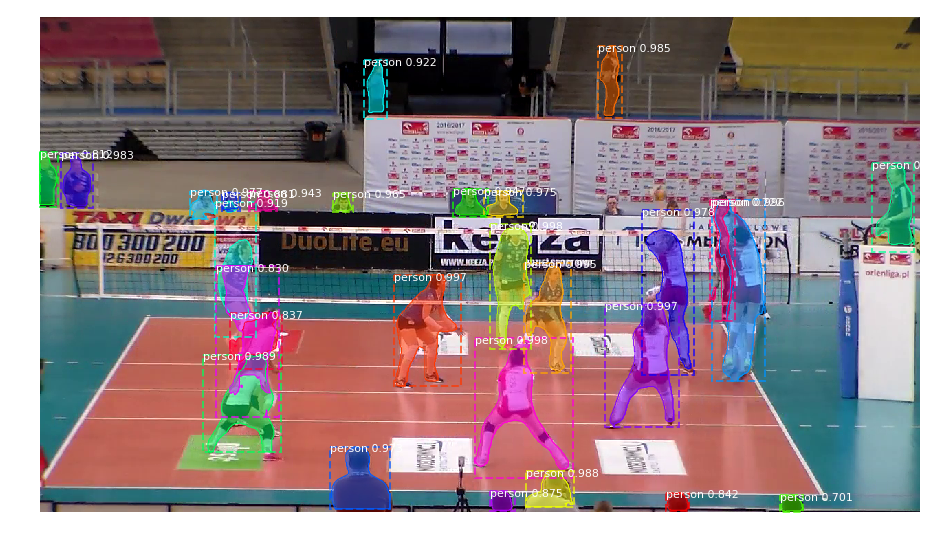

In [118]:
fpath = metadata['fpath'][245]
img = skimage.io.imread(fpath)
det_fpath = Path(DETECTIONS_DIR, Path(fpath).name + '.npy')
det = np.load(det_fpath)[0]
visualize.display_instances(img, det['rois'], det['masks'], det['class_ids'], 
                            class_names, det['scores'])

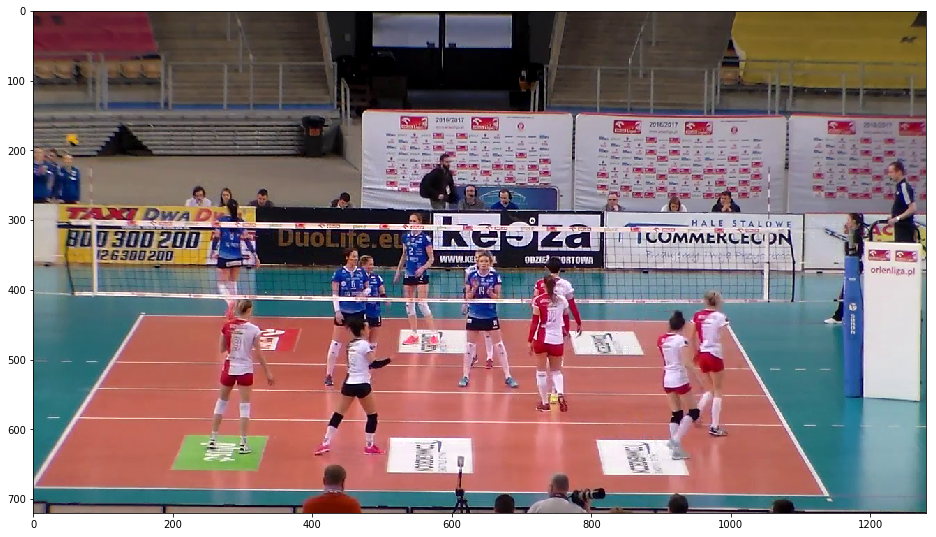

In [135]:
fig, ax = plt.subplots(1, figsize=(16,16))
img = skimage.io.imread(metadata['fpath'][0])
imgplot = ax.imshow(img, animated=True)
def init():
    return (imgplot,)

def animate(fpath):
    ax.clear()
    img = skimage.io.imread(fpath)
    det_fpath = Path(DETECTIONS_DIR, Path(fpath).name + '.npy')
    det = np.load(det_fpath)[0]
    imgplot = create_display_img(
        img, det['rois'], det['masks'], det['class_ids'], 
        class_names, scores=det['scores'], ax=ax
    )
    return (imgplot,)

In [141]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=metadata['fpath'][:300], interval=40, blit=False)

In [142]:
# ~1 minute to generate
HTML(anim.to_html5_video())